<div style="font-family: Calibri; font-size: 16px; background-color: #ccd5ae; padding: 10px 10px;">
    <h1>KNN</h1>
</div>

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn import set_config
from sklearn.dummy import DummyClassifier
from scripts.plot import plot_two_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from scripts.plot_tetha import plot_model
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, fbeta_score

In [2]:
%load_ext autoreload
%autoreload 2
from scripts.scores import calc_predict_proba, calc_scores, confusion_matrix_display

In [3]:
warnings.filterwarnings("ignore") 
set_config(display='diagram')
pd.options.display.precision=3
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<div style="font-family: Calibri; font-size: 16px; background-color: #faedcd; padding: 5px;">
    <h2>1. Loading Train and Test dataset</h2>
    <p>Train-Test split is not required, as both dataset provided are separate.</p>
</div>

In [4]:
df = pd.read_csv("data/train.csv" )
df.shape

(255347, 18)

In [7]:
X_train = df.drop(columns=['Default', 'LoanID', 'DTIRatio', 'CreditScore'])
y_train = df['Default']
print(X_train.shape)
print(y_train.shape)

(255347, 14)
(255347,)


<div style="font-family: Calibri; font-size: 16px; background-color: #e9edc9; padding: 5px;">
    <h4>- Using RandomUnderSampler</h4>
</div>

In [8]:
from imblearn.under_sampling import RandomUnderSampler

In [9]:
# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Fit and apply the undersampling
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [10]:
# The resampled data is now balanced
print("Shape of X before undersampling:", X_train.shape)
print("Shape of X after undersampling:", X_resampled.shape)
print("Value counts before undersampling:", pd.Series(y_train).value_counts())
print("Value counts after undersampling:", pd.Series(y_resampled).value_counts())

Shape of X before undersampling: (255347, 14)
Shape of X after undersampling: (59306, 14)
Value counts before undersampling: Default
0    225694
1     29653
Name: count, dtype: int64
Value counts after undersampling: Default
0    29653
1    29653
Name: count, dtype: int64


In [11]:
X_train, y_train = X_resampled, y_resampled

In [12]:
df_test = pd.read_csv("data/test.csv")
df_predictions = pd.read_csv("data/prediction_submission.csv")
df_predictions.shape

(109435, 2)

In [13]:
X_test = df_test.drop(columns=['LoanID', 'DTIRatio', 'CreditScore'])
y_test =  df_predictions['predicted_probability']
print(X_test.shape)
print(y_test.shape)

(109435, 14)
(109435,)


<hr>
<div style="font-family: Calibri; font-size: 16px; background-color: #faedcd; padding: 5px 5px 5px 5px;">
    <h2>2. Column Transformation</h2>
</div>

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

<div style="font-family: Calibri; font-size: 18px; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h3>Univariate Analysis - Conclusion (Recap)</h3>    
    <ul>
            <li>HasCoSigner, HasDependents, HasMortgage are binary fields</li>
            <li>Education, EmploymentType, LoanPurpose, MaritalStatus are categorical data</li>
    </ul>        
    <h4>Transformation is done external to pipeline to avoid the redundent step In GridSearchCV
    </h4>
</div>

In [15]:
transformer = ColumnTransformer(
    [
        ('Binary', OneHotEncoder(), ['HasCoSigner', 'HasDependents', 'HasMortgage']),
        ('multi_category', OneHotEncoder(),  ['Education', 'EmploymentType', 'MaritalStatus']),
        ('Loan_category', OneHotEncoder(categories = [['Business', 'Home']], handle_unknown='ignore'), ['LoanPurpose']),    
    ], remainder=MinMaxScaler()
)

In [16]:
X_train = transformer.fit_transform(X_train)

In [17]:
X_test = transformer.transform(X_test)

<div style="font-family: Calibri; font-size: 16px; background-color: #faedcd; padding: 5px;">
    <h2>3. KNearestNeighbor</h2>
    <font size=4>        
    <ul>
        <li>GridSearchCV</li>
    </ul>
    </font>
</div>

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
knn = KNeighborsClassifier()

In [20]:
param_grid = {
    'n_neighbors': list(range(10, 21, 2)),
    'weights': ['uniform', 'distance']
}

In [21]:
cv = GridSearchCV(knn, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=True);

In [22]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [10, 12, 14, 16, 18, 20],
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=True)

In [23]:
print("Best Parameters:", cv.best_params_)
print("Best CV Score:", cv.best_score_)

Best Parameters: {'n_neighbors': 20, 'weights': 'distance'}
Best CV Score: 0.6336631521064473


In [24]:
model = cv.best_estimator_
model

KNeighborsClassifier(n_neighbors=20, weights='distance')

In [25]:
X_pred = model.predict(X_test)

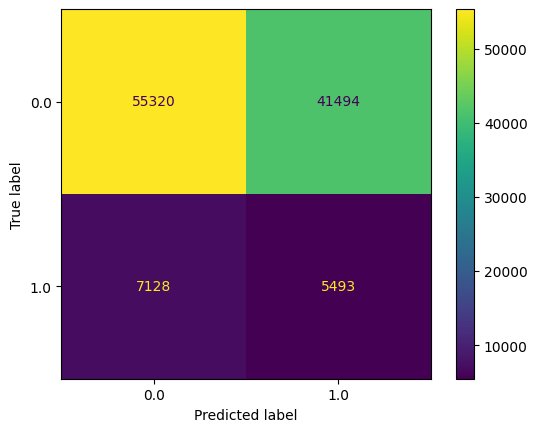

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, X_pred, values_format='d');

In [28]:
rs = recall_score(y_test, X_pred, pos_label=1)
ps = precision_score(y_test, X_pred, pos_label=1)
f1 = f1_score(y_test, X_pred, pos_label=1, average='micro')
ac = accuracy_score(y_test, X_pred)

In [29]:
print(f"{'Recall Score:':<20}{rs:<5}")
print(f"{'Precision Score:':<20}{ps:<5}")
print(f"{'F1 Score:':<20}{f1:<5}")
print(f"{'Accuracy Score:':<20}{ac:<5}")

Recall Score:       0.43522700261468983
Precision Score:    0.1169046757613808
F1 Score:           0.5556997304335907
Accuracy Score:     0.5556997304335907


In [42]:
y_train_pred_prob, y_test_pred_prob = calc_predict_proba(model, X_train, y_train, X_test, y_test)

In [43]:
rs_list, ps_list, f1_list, ac_list = [],[],[],[]
for thresh in np.arange(0.3,0.8,0.1):
    rs, ps, f1, ac, y_test_pred = calc_scores(model, X_train, y_train, y_train_pred_prob, X_test, y_test, y_test_pred_prob, thresh)
    rs_list.append(rs) 
    ps_list.append(ps)
    f1_list.append(f1)
    ac_list.append(ac)

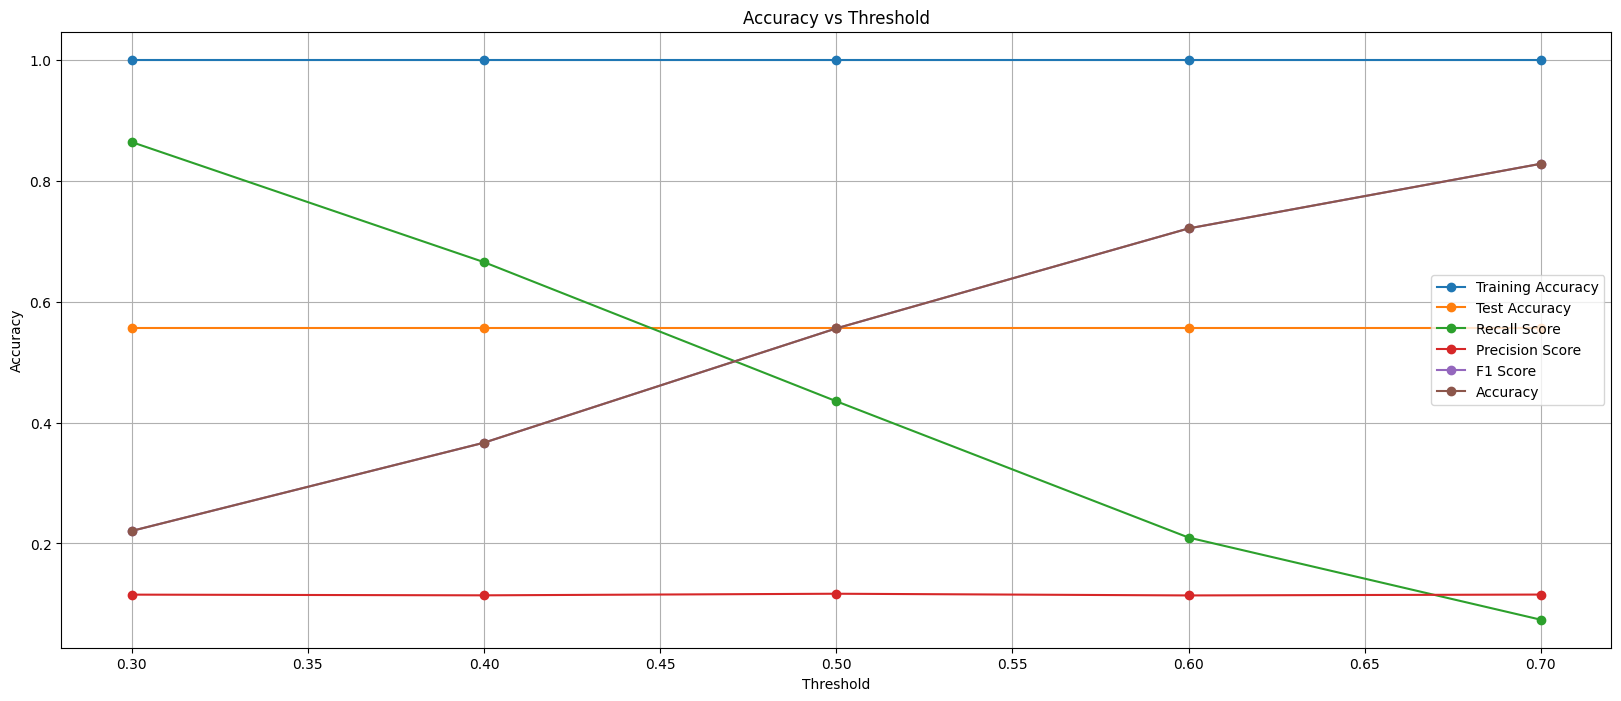

In [44]:
plt.figure(figsize=(10, 4))

plt.plot(np.arange(0.3,0.8,0.1), rs_list, label='Recall Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ps_list, label='Precision Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), f1_list, label='F1 Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ac_list, label='Accuracy', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

<div style="font-family: Calibri; font-size: 16px; background-color: #e9edc9; padding: 5px;">
    <h4>- Using RandomOverSampler</h4>
</div>